In [3]:
import scipy.stats
from einops import rearrange

%load_ext autoreload
%autoreload 2

import pickle
from dataclasses import dataclass
from pathlib import Path
import torchvision.transforms.functional as F

import matplotlib.pyplot as plt
import numpy as np
import wandb
from torch import nn
import torch

from enc import PE, IPE
from model import MLP
from pipeline.evaluation import evaluate_model_across_scales, evaluate_model_multires
from pipeline.log_image import TrainImage
from pipeline.train import TrainingSettings, train_model
from wandb_util import first_used_artifact_of_type

from torchmetrics.functional import peak_signal_noise_ratio

In [4]:
@dataclass
class ExperimentModel:
    # info about saved model
    display_name: str
    artifact_name: str

    model: nn.Module
    encoding: nn.Module
    training_set_artifact: str

    def train(self, train_settings: TrainingSettings, group_name=None):
        train_model(self.model,
                    self.encoding,
                    self.training_set_artifact,
                    self.artifact_name,
                    train_settings,
                    run_name=f'train-{self.display_name}',
                    group_name=group_name)

    def eval_across_scales(self, lo, hi, count, group_name=None):
        evaluate_model_across_scales(f'{self.artifact_name}:latest',
                                     lo, hi, count,
                                     run_name=self.display_name,
                                     group_name=group_name)

In [5]:
pe = PE(d_in=2, n_freqs=10)
ipe = IPE(d_in=2, n_freqs=10)
model = MLP(pe.d_output)

models = [
    ExperimentModel('PE-single', 'pe-single', model, pe, 'collins-single-macro:latest'),
    ExperimentModel('IPE-single', 'ipe-single', model, ipe, 'collins-single-macro:latest'),
    ExperimentModel('PE-focused', 'pe-focused', model, pe, 'collins-focused-macro:latest'),
    ExperimentModel('IPE-focused', 'ipe-focused', model, ipe, 'collins-focused-macro:latest'),
    ExperimentModel('PE-multi', 'pe-multi', model, pe, 'collins-multi-macro:latest'),
    ExperimentModel('IPE-multi', 'ipe-multi', model, ipe, 'collins-multi-macro:latest')
]

In [6]:
train_settings = TrainingSettings()
train_settings.batch_size = 2000
train_settings.n_epochs = 20
train_settings.lr = 0.002
train_settings.batch_size = 2000
train_settings.n_samples = 100000

def train_models(models, train_settings: TrainingSettings, group_name=None):
    for model in models:
        model.train(train_settings, group_name=group_name)

re_train = False

if re_train:
    for model in models:
        model.train(train_settings, group_name='100k')

# Experiment: Find optimal render-sigma

In [7]:
out_res = 100

n_steps = 50
scales = [
    # (20, 0.01, 0.05),
    # (25, 0.01, 0.05),
    # (30, 0.007, 0.03),
    # (35, 0.01, 0.05),
    # (50, 0, 0.02),
    # (60, 0, 0.02),
    # (75, 0, 0.02),
    # (100, 0, 0.015),
    # (150, 0, 0.015),
    # (200, 0, 0.01),
    # (250, 0, 0.01),
    # (300, 0, 0.01),
    # (350, 0, 0.01),
    # (400, 0, 0.01),
    # (450, 0, 0.01),
    # (500, 0, 0.01),
]

for res, lo, hi in scales:
    evaluate_model_across_scales(f'{models[-1].artifact_name}:latest', lo, hi, n_steps, res,
                                 run_name=f'{res}-{lo}-{hi}')

In [7]:
api = wandb.Api()

runs = api.runs(path="romeu/mip-NeRF2D")
runs = [r for r in runs if r.job_type == "evaluation-render-multiscale"]
runs = sorted(runs, key=lambda r: int(r.config['res']))

resolutions = []
opt_scales_pnsr = []
opt_scales_ssim = []
opt_scales_mse = []

for r in runs:
    h = r.history()
    pnsrs = h['pnsr']
    mses = h['mse']
    ssims = h['ssim']

    scales = h['scale']

    opt_scale_pnsr = scales[np.argmax(pnsrs)]
    opt_scale_ssim = scales[np.argmax(ssims)]
    opt_scale_mse = scales[np.argmax(mses)]

    resolutions.append(r.config['res'])
    opt_scales_mse.append(opt_scale_mse)
    opt_scales_ssim.append(opt_scale_ssim)
    opt_scales_pnsr.append(opt_scale_pnsr)

[ 20  25  25  30  35  35  50  60  75 100 150 200 250 300 350 400 450 500]
0.40971826587464744
0.0018586625762174033


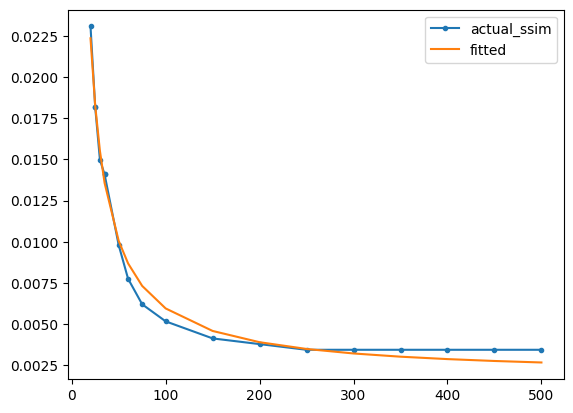

In [8]:
resolutions = np.array(resolutions)

print(resolutions)

x = 1 / resolutions

regression = scipy.stats.linregress(x, opt_scales_ssim)

print(regression.slope)
print(regression.intercept)

def res_to_scale(x):
    return regression.slope / x + regression.intercept

x = resolutions

x_eval = np.linspace(min(resolutions), 900, 100)
y = res_to_scale(x)

# plt.plot(x, opt_scales_pnsr, label='actual_pnsr', marker='.')
# plt.plot(x, opt_scales_mse, label='actual_mse', marker='.')
plt.plot(x, opt_scales_ssim, label='actual_ssim', marker='.')
plt.plot(x, y, label='fitted')
# plt.ylim(0, 0.025)
plt.legend()



# Experiment 2: Multiscale-evaluation

In [ ]:
res = 512
group_name = 'multiscale'

from model_evaluation import res_to_scale

for model in models:
    evaluate_model_across_scales(model.artifact_name,
                                 0, res_to_scale(1), count=10, res=res,
                                 run_name=f'multiscale-{model.display_name}',
                                 group_name='multiscale')

[autoreload of wandb.sdk.internal.thread_local_settings failed: Traceback (most recent call last):
  File "/home/jorge/fun/mip-NeRF2D/venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/jorge/fun/mip-NeRF2D/venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/jorge/fun/mip-NeRF2D/venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/jorge/fun/mip-NeRF2D/venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/home/jorge/fun/mip-NeRF2D/venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: can't apply this __setattr__ to _ThreadLocalApiSettings object
]
[

# Experiment 1:  Multires evaluation

In [6]:
def evaluate_models_multires(models, low, high, steps, experiment_name: str):
    resolutions = np.linspace(low, high, steps).astype(int)

    for model in models:
        evaluate_model_multires(f'{model.artifact_name}:latest',
                                resolutions,
                                run_name=model.display_name,
                                group_name=experiment_name,
                                output_artifact_name=f'{model.display_name}-{experiment_name}')

evaluate_models_multires(models, 32, 512, 10, 'multiscale-evaluation-0.3')

wandb:   3 of 3 files downloaded.  
wandb:   1 of 1 files downloaded.  


mse,█▁▁▂▂▃▃▃▄▅
pnsr,▁██▇▆▅▅▅▄▃
res,▁▂▃▃▄▅▆▆▇█
ssim,▇█▆▅▄▃▂▂▂▁
mse,0.00527
pnsr,22.77932
res,512
ssim,0.6873


wandb:   3 of 3 files downloaded.  
wandb:   1 of 1 files downloaded.  


mse,█▁▁▂▂▃▃▄▄▆
pnsr,▁██▇▆▅▅▅▄▃
res,▁▂▃▃▄▅▆▆▇█
ssim,██▇▅▄▃▃▂▂▁
mse,0.00415
pnsr,23.81958
res,512
ssim,0.7258


wandb:   3 of 3 files downloaded.  
wandb:   1 of 1 files downloaded.  


mse,█▂▁▁▁▂▂▂▂▃
pnsr,▁▇██▇▆▆▆▆▄
res,▁▂▃▃▄▅▆▆▇█
ssim,▆█▇▆▅▄▃▃▂▁
mse,0.00351
pnsr,24.55108
res,512
ssim,0.74302


wandb:   3 of 3 files downloaded.  
wandb:   1 of 1 files downloaded.  


mse,█▂▁▁▂▂▂▃▃▄
pnsr,▁▇█▇▇▆▆▅▅▃
res,▁▂▃▃▄▅▆▆▇█
ssim,▇█▇▆▅▄▃▃▂▁
mse,0.00333
pnsr,24.77411
res,512
ssim,0.76006


wandb:   3 of 3 files downloaded.  
wandb:   1 of 1 files downloaded.  


mse,█▁▁▁▂▂▂▃▃▄
pnsr,▁▇█▇▆▅▅▅▄▃
res,▁▂▃▃▄▅▆▆▇█
ssim,▆█▇▆▅▄▃▃▂▁
mse,0.00339
pnsr,24.69384
res,512
ssim,0.75467


wandb:   3 of 3 files downloaded.  
wandb:   1 of 1 files downloaded.  


mse,█▁▁▂▂▃▄▄▅▇
pnsr,▁██▆▅▅▄▄▃▂
res,▁▂▃▃▄▅▆▆▇█
ssim,▇█▇▆▅▄▃▃▂▁
mse,0.00318
pnsr,24.97679
res,512
ssim,0.76523


In [ ]:
# download artifact results
artifacts = [api.artifact(f'romeu/mip-NeRF2D/{model.display_name}-multiscale-high-range:latest') for model in models]
artifact_dirs = [Path(art.download()) for art in artifacts]

In [223]:
# compute ground truth renders
eval_run = artifacts[0].logged_by()
model_artifact = first_used_artifact_of_type(eval_run, 'model')
training_run = model_artifact.logged_by()
dataset = first_used_artifact_of_type(training_run, 'multiscale-dataset')
dataset_creation_run = dataset.logged_by()
image_artifact = first_used_artifact_of_type(dataset_creation_run, 'image')

ground_truth = TrainImage.from_artifact(image_artifact)

wandb:   1 of 1 files downloaded.  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


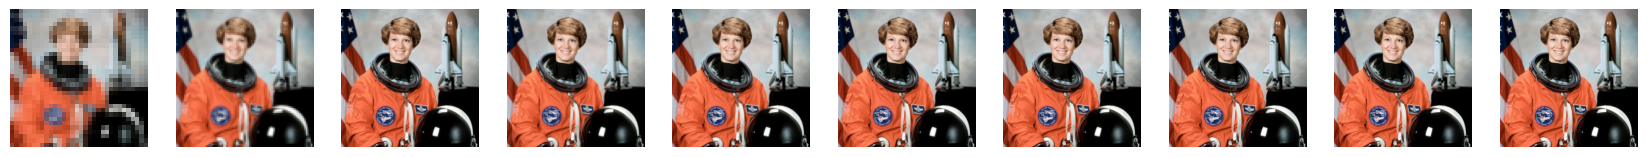

In [224]:
with open(artifact_dirs[0] / 'renders.pkl', 'rb') as f:
    renders = pickle.load(f)

resolutions = [r.shape[1] for r in renders]

truths = [F.resize(ground_truth.im, int(res), antialias=True) for res in resolutions]

size = 21
fig, axs = plt.subplots(1, len(resolutions), figsize=(size, size * len(resolutions)))
for i, truth in enumerate(truths):
    axs[i].imshow(rearrange(truth, 'c h w -> h w c'))
    axs[i].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/jorge/fun/mip-NeRF2D/venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(


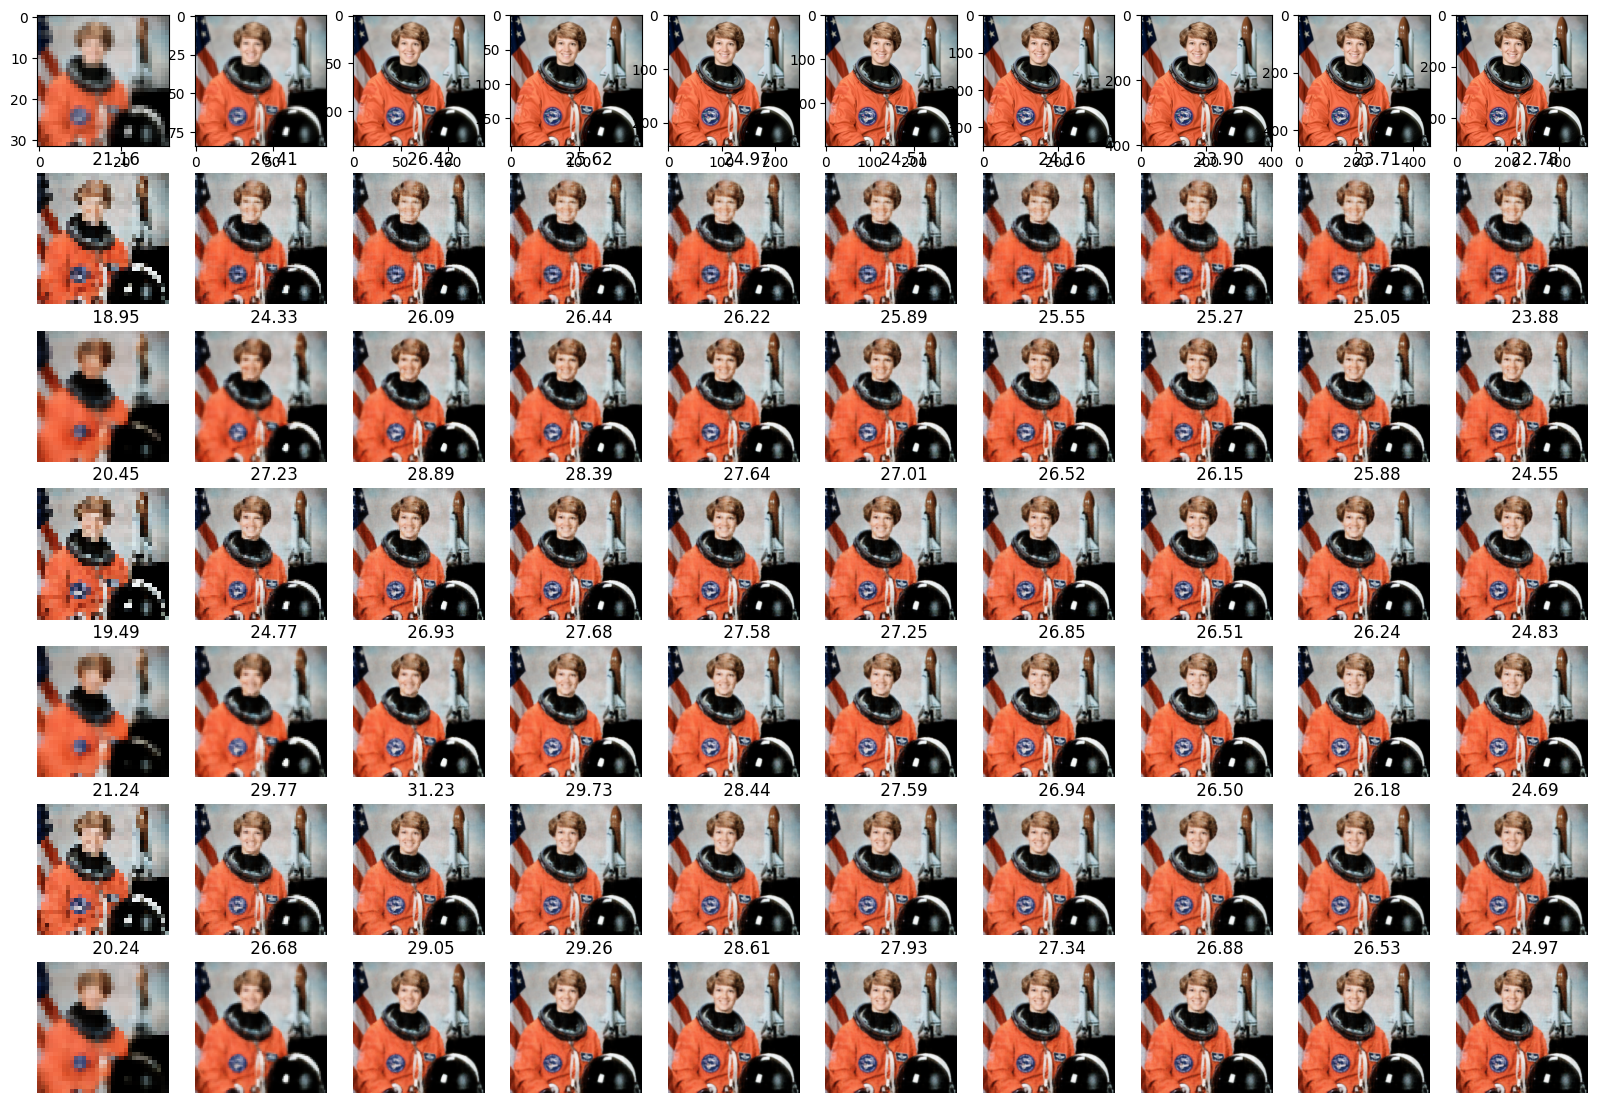

In [226]:
size = 2
W, H = len(artifacts) + 1, len(resolutions)
fig, axs = plt.subplots(W, H, figsize=(size * H, size * W))

ssims = np.zeros((len(models), len(resolutions)))

for i, truth in enumerate(truths):
    ax = axs[0, i]
    ax.imshow(rearrange(truths[i], 'c h w -> h w c'))

for model_i, art_dir in enumerate(artifact_dirs):

    with open(art_dir / 'renders.pkl', 'rb') as f:
        renders = pickle.load(f)

    for render_i, render in enumerate(renders):
        ax = axs[model_i + 1, render_i]

        truth = truths[render_i]

        pnsr = peak_signal_noise_ratio(torch.Tensor(render).unsqueeze(0), truth.unsqueeze(0))
        ssims[model_i, render_i] = pnsr

        ax.set_title(f'{pnsr.item():10.2f}')
        ax.imshow(rearrange(render, 'c h w -> h w c'))
        ax.axis('off')

plt.show()

In [ ]:
from tabulate import tabulate

table = tabulate(pnsrs, headers=resolutions, showindex=[model.display_name for model in models])
print(table)